In [17]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

device = device = "cuda" if torch.cuda.is_available() else "cpu"

# Code Analasis

In [18]:
train = torch.load('/mnist_train.pt')
x,y = train.data, train.targets
print(x.shape)

torch.Size([60000, 28, 28])


In [19]:
class MNISTDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()
        self.x, self.y = dataset.data, dataset.targets
        self.x = self.x / 255 # we want values in between 0 and 1, 255 is the max for colors 0-255
        self.y = F.one_hot(self.y, num_classes=10).to(float)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]


tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)


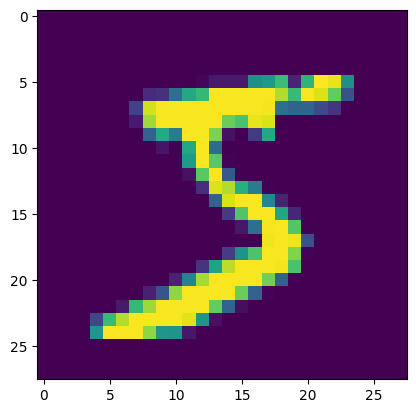

In [20]:
train = MNISTDataset(torch.load('/mnist_train.pt'))
test = MNISTDataset(torch.load('/mnist_test.pt'))
print(train[0][1])
plt.imshow(x[0])

In [21]:
train_dl = DataLoader(train, batch_size=8, shuffle=False)

In [22]:
len(train_dl)

7500

In [23]:
# training without batch norm
class Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1 = nn.Linear(28**2, 200) # beacause x.shape = 60000, 28, 28 we make the stating layer 28 to the power of 2
        self.ln2 = nn.Linear(200,50)
        self.ln3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

        init.kaiming_uniform_(self.ln1.weight)
        init.kaiming_uniform_(self.ln2.weight)
        init.kaiming_uniform_(self.ln3.weight)

    def forward(self, x):
        x = x.view(-1, 28**2)
        x = self.relu(self.ln1(x))
        x = self.relu(self.ln2(x))
        x = self.ln3(x)

        return x.squeeze


In [24]:
# training with batch norm
class BrainWBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1 = nn.Linear(28**2, 200) # beacause x.shape = 60000, 28, 28 we make the stating layer 28 to the power of 2
        self.ln2 = nn.Linear(200,50)
        self.ln3 = nn.Linear(50, 10)

        self.bn1 = nn.LayerNorm(200)
        self.bn2 = nn.LayerNorm(50)
        self.bn3 = nn.LayerNorm(10)

        self.relu = nn.ReLU()

        init.kaiming_uniform_(self.ln1.weight)
        init.kaiming_uniform_(self.ln2.weight)
        init.kaiming_uniform_(self.ln3.weight)

    def forward(self, x):
        x = x.view(-1, 28**2)
        x = self.ln1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.ln2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.ln3(x)
        x = self.bn3(x)
        x = self.relu(x)

        return x.squeeze()


In [25]:
criterion = nn.CrossEntropyLoss()

In [37]:
brain = Brain()
brainWBatchNorm = BrainWBatchNorm()

xs, ys = train[0:4]

output_without_batch_norm = brain(xs)
loss_without_batch_norm = criterion(output_without_batch_norm, ys)
print("without batch norm: ", output_without_batch_norm[0], "\nLoss: ", loss_without_batch_norm)

output_with_batch_norm = brainWBatchNorm(xs)
loss_with_batch_norm = criterion(output_with_batch_norm, ys)
print("with batch norm: ", output_with_batch_norm[0], "\nLoss: ", loss_with_batch_norm)



without batch norm:  tensor([-0.4372, -0.7249,  0.5112, -1.0331, -0.0990, -1.8980,  0.6734,  0.2038,
        -0.2267, -0.5380], grad_fn=<SelectBackward0>) 
Loss:  tensor(2.8139, dtype=torch.float64, grad_fn=<DivBackward1>)
with batch norm:  tensor([0.8213, 0.0000, 0.0000, 0.0000, 0.0000, 1.4088, 1.0529, 0.3755, 0.6920,
        0.1347], grad_fn=<SelectBackward0>) 
Loss:  tensor(1.9939, dtype=torch.float64, grad_fn=<DivBackward1>)


In [47]:
# we can see that the loss is actually better with batch normalization so moving forward we will use the first model brain
brain=BrainWBatchNorm().to(device)
optimizer = Adam(brain.parameters(), lr=0.01)
loss_arr = []
epoch_arr = []


for epoch in range(30):
    print(epoch)
    size = len(train_dl)
    for i, (x, y) in enumerate(train_dl):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        logits = brain(x)
        loss = criterion(logits, y).to(device)
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch + i/size)
        loss_arr.append(loss.item())

loss_arr = np.array(loss_arr)
epoch_arr = np.array(epoch_arr)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


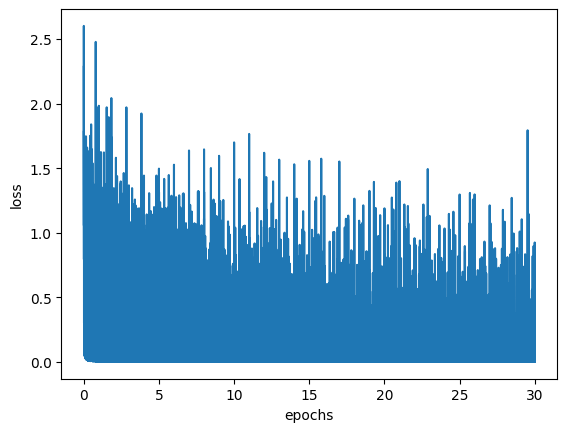

In [48]:
plt.plot(epoch_arr, loss_arr)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

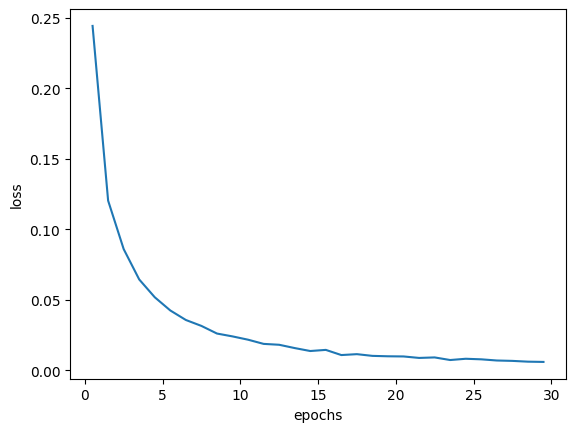

In [49]:
plt.plot(epoch_arr.reshape(30, -1).mean(axis=1), loss_arr.reshape(30, -1).mean(axis=1))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [50]:
x_sample = train[0][0].to(device)
pred = brain(x_sample)
torch.argmax(pred)

tensor(5)

<ipython-input-51-8a4d6898247b>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10,3,i+1)


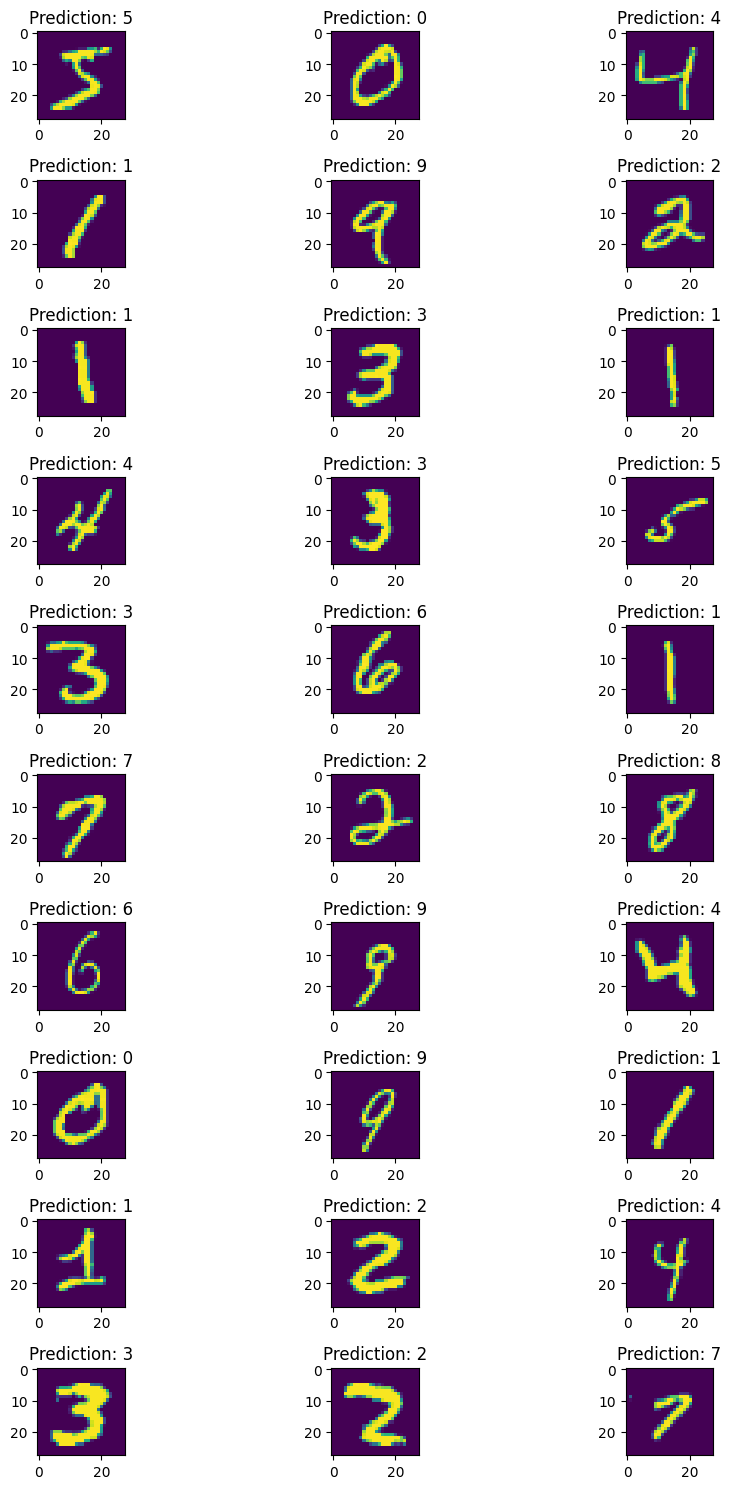

In [51]:
xs, ys = train[0:2000]
xs, ys = xs.to(device), ys.to(device)
preds = brain(xs).argmax(axis=1)

fig, ax = plt.subplots(20,12,figsize=(10,15))
for i in range(30):
    plt.subplot(10,3,i+1)
    plt.imshow(xs[i].cpu().numpy())
    plt.title(f'Prediction: {preds[i]}')
fig.tight_layout()
plt.show()

<ipython-input-52-d7c51cac4ad4>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10,3,i+1)


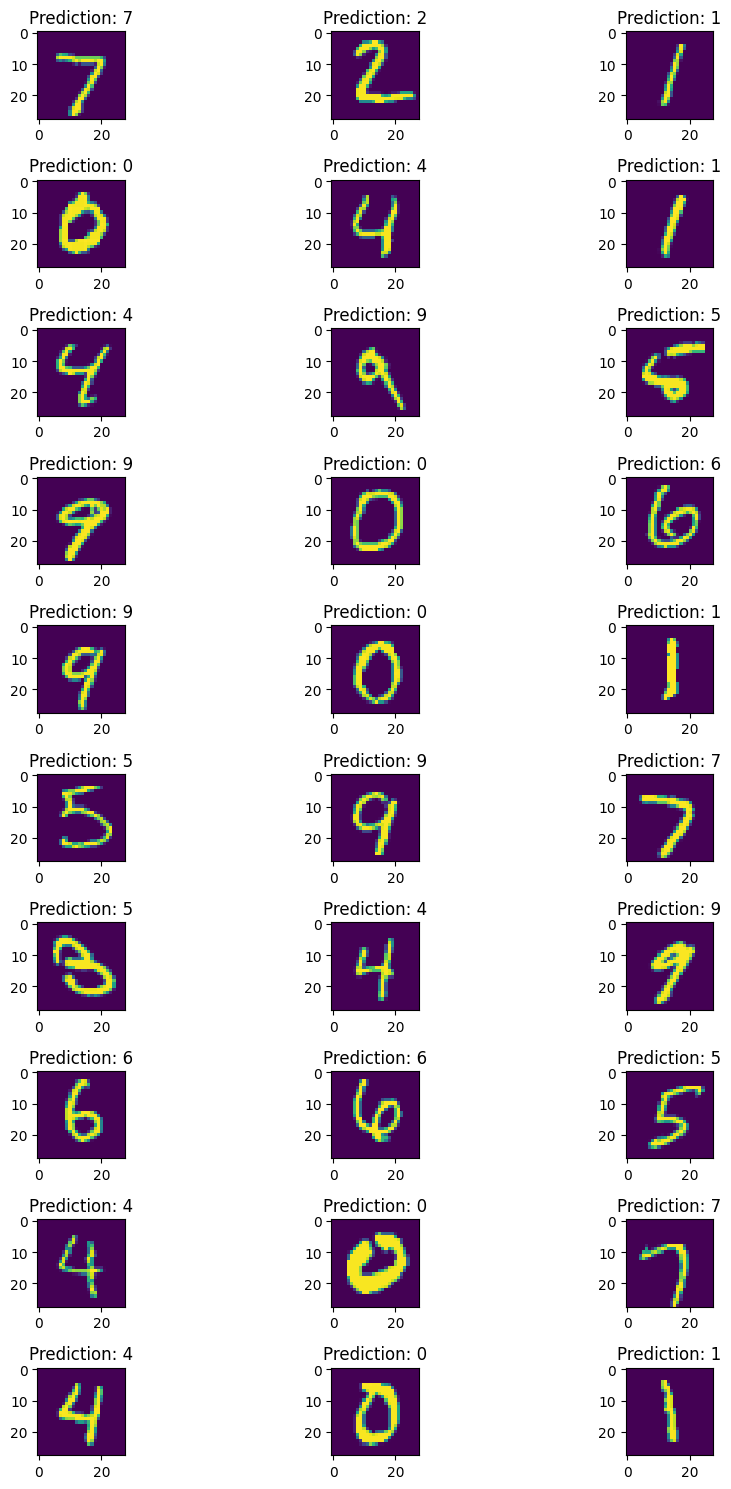

In [52]:
# run it on the test set
xs, ys = test[0:2000]
xs, ys = xs.to(device), ys.to(device)
preds = brain(xs).argmax(axis=1)

fig, ax = plt.subplots(20,12,figsize=(10,15))
for i in range(30):
    plt.subplot(10,3,i+1)
    plt.imshow(xs[i].cpu().numpy())
    plt.title(f'Prediction: {preds[i]}')
fig.tight_layout()
plt.show()